## Dimensionless multiplicity function $M^2 n(M)/\bar\rho$ and linear halo bias $b(M)$

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb

# Project imports
import pyhalomodel as halo
import pyhalomodel.camb_stuff as camb_stuff

In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 1.97448e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # in eV
sigma_8_set = True # If true uses the following value
sigma_8  = 0.8

# Halo mass range [Msun/h]
Mmin = 1e7; Mmax = 1e17; nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# CAMB parameters
zmax_CAMB = 2.
kmax_CAMB = 200.

# Redshifts
z = 0.
zs = [1., 0.] # CAMB reorders from high-z to low-z, so we define it like this from the start to avoid confusion

In [4]:
# CAMB
Pk_lin, camb_results, Omega_m, _, _ = camb_stuff.run(zs, Omega_c, Omega_b, Omega_k, h, ns, sigma_8)

In [5]:
mass_functions = [
    'Sheth & Tormen (1999)',
    'Tinker et al. (2010)',
    'Despali et al. (2016)',
]

# Calculate b(M) and n(M)
bs, Fs = [], []
for iz, z in enumerate(zs):
    for mass_function in mass_functions:
        print(mass_function, 'z = %1.1f'%(z))
        hmod = halo.model(z, Omega_m, name=mass_function, Dv=330.)
        Rs = hmod.Lagrangian_radius(Ms)
        sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[zs.index(z)]
        b = hmod.linear_bias(Ms, sigmaRs)
        F = hmod.multiplicity_function(Ms, sigmaRs)
        bs.append(b)
        Fs.append(F)

Sheth & Tormen (1999) z = 1.0
Tinker et al. (2010) z = 1.0
Despali et al. (2016) z = 1.0
Sheth & Tormen (1999) z = 0.0
Tinker et al. (2010) z = 0.0
Despali et al. (2016) z = 0.0


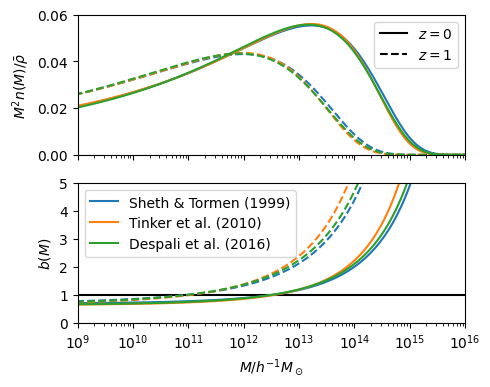

In [6]:
# Make the plot
plt.subplots(2, 1, figsize=(5, 4), dpi=100, sharex=True)
n = len(mass_functions)
Mmin_plot, Mmax_plot = 1e9, 1e16

# Mass function
plt.subplot(2, 1, 1)
plt.plot(Ms[0], np.nan, color='black', ls='-', label=r'$z=0$')
plt.plot(Ms[0], np.nan, color='black', ls='--', label=r'$z=1$')
for i, mass_function in enumerate(mass_functions):
    plt.plot(Ms, Fs[i], ls='--', color='C%d'%i)
    plt.plot(Ms, Fs[i+n], ls='-', color='C%d'%i)
plt.xscale('log')
plt.gca().set_xticklabels([])
plt.ylim((0., 0.06))
plt.ylabel(r'$M^2 n(M)/\bar\rho$')
plt.xlim((Mmin_plot, Mmax_plot))
plt.legend()

# Linear bias
plt.subplot(2, 1, 2)
plt.axhline(1., color='black')
for i, mass_function in enumerate(mass_functions):
    plt.plot(Ms, bs[i], ls='--', color='C%d'%i)
    plt.plot(Ms, bs[i+n], ls='-', color='C%d'%i, label=mass_function)
plt.xlabel(r'$M / h^{-1} M_\odot$')
plt.xscale('log')
plt.ylim((0., 5.))
plt.ylabel(r'$b(M)$')

# Common x-axis
plt.xlim((Mmin_plot, Mmax_plot))
plt.legend()

plt.savefig('plots/hmf_and_bias.pdf',bbox_inches='tight')
plt.show()